[*********************100%***********************]  1 of 1 completed


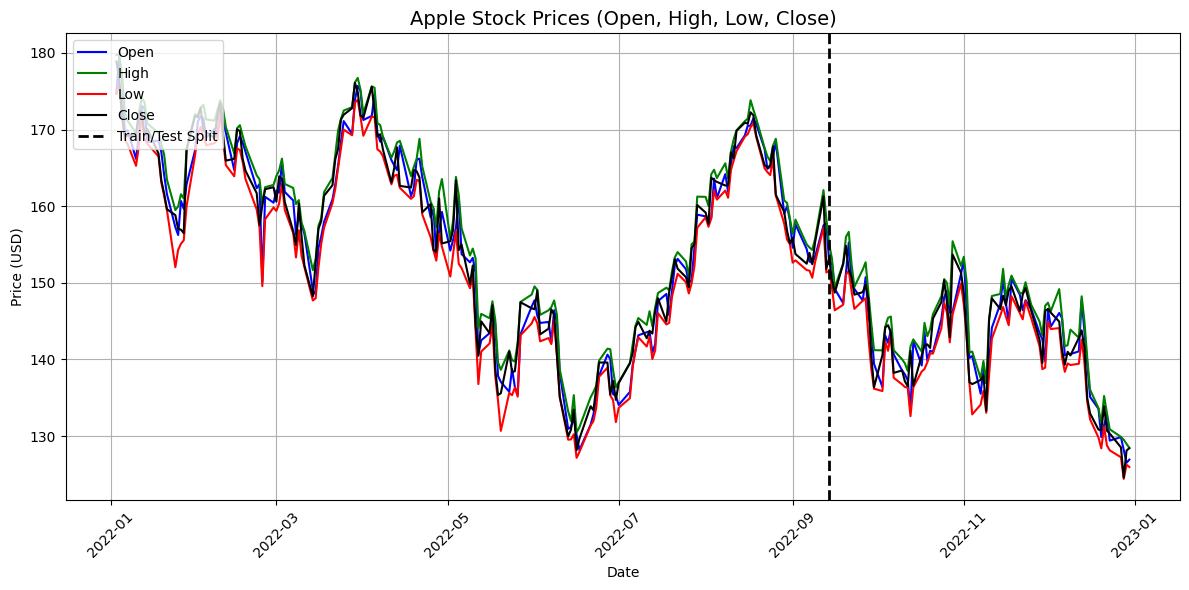

Training data shape: (175, 4)
Testing data shape: (76, 4)
Train RMSE: 2.8757323852289556
Test RMSE: 4.664071252180714


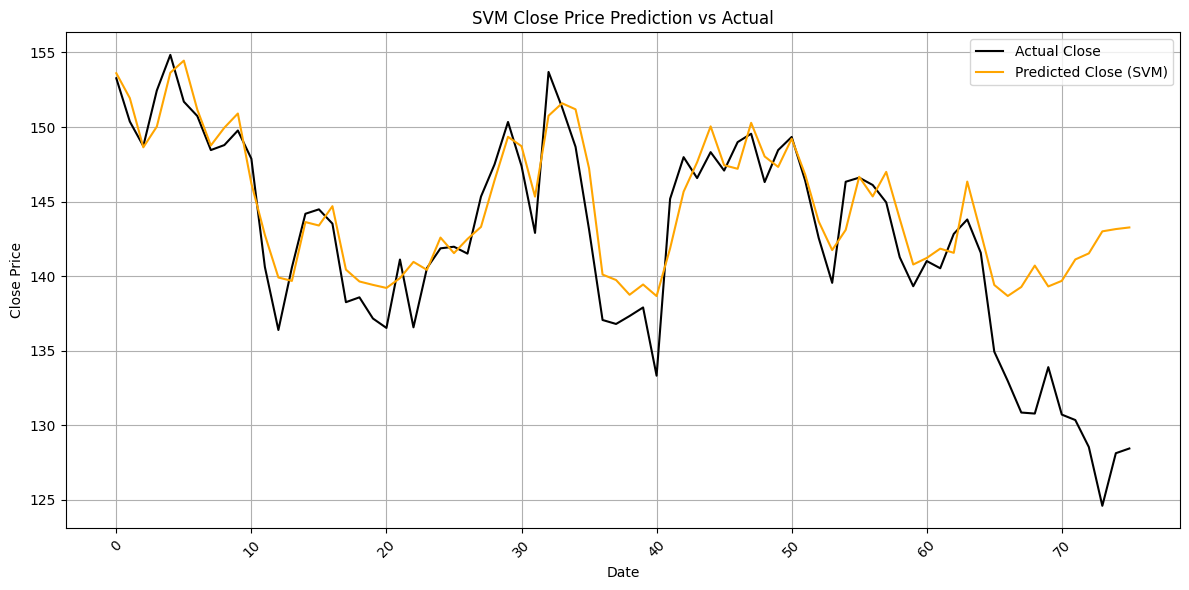

Predicted closing price for the next day: 143.26390441149363


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Download Apple's stock market data
ticker = 'AAPL'
df = yf.download(ticker, start='2022-01-01', end='2023-01-01')

# Step 2: Select specific columns
columns = ['Open', 'High', 'Low', 'Close']
data = df[columns]

# Step 3: Plot the stock prices with train-test split marker
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Open'], label='Open', color='blue')
plt.plot(data.index, data['High'], label='High', color='green')
plt.plot(data.index, data['Low'], label='Low', color='red')
plt.plot(data.index, data['Close'], label='Close', color='black')

# Vertical dashed line for train/test split
split_index = int(len(data) * 0.7)
split_date = data.index[split_index]
plt.axvline(x=split_date, color='black', linestyle='--', linewidth=2, label='Train/Test Split')

# Plot formatting
plt.title('Apple Stock Prices (Open, High, Low, Close)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend(loc='upper left')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Step 4: Convert to NumPy array for easier slicing
dataset = data.values

# Step 5: Split into train and test sets (70% train, 30% test)
size = int(len(dataset) * 0.7)
df_train = dataset[:size].copy()
df_test = dataset[size:].copy()

print("Training data shape:", df_train.shape)
print("Testing data shape:", df_test.shape)

# Step 6: Convert back to DataFrame
df_train = pd.DataFrame(df_train, columns=columns)
df_test = pd.DataFrame(df_test, columns=columns)

# Step 7: Define features and target
X_train = df_train[['Open', 'High', 'Low']]
y_train = df_train['Close']

X_test = df_test[['Open', 'High', 'Low']]
y_test = df_test['Close']

# Step 8: Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 9: Train the SVR model
svm_model = SVR(kernel='rbf')  # Try also 'linear' or 'poly'
svm_model.fit(X_train_scaled, y_train)

# Step 10: Predict on train and test data
y_train_pred = svm_model.predict(X_train_scaled)
y_test_pred = svm_model.predict(X_test_scaled)

# Step 11: Evaluate the model
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))

print("Train RMSE:", rmse_train)
print("Test RMSE:", rmse_test)

# Step 12: Visualize actual vs predicted Close prices on test set
plt.figure(figsize=(12, 6))
plt.plot(df_test.index, y_test, label='Actual Close', color='black')
plt.plot(df_test.index, y_test_pred, label='Predicted Close (SVM)', color='orange')
plt.title('SVM Close Price Prediction vs Actual')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print the last predicted next-day closing price
last_prediction = y_test_pred[-1]
print("Predicted closing price for the next day:", last_prediction)

In [5]:
!pip install mapie


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.1/178.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 13.1 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


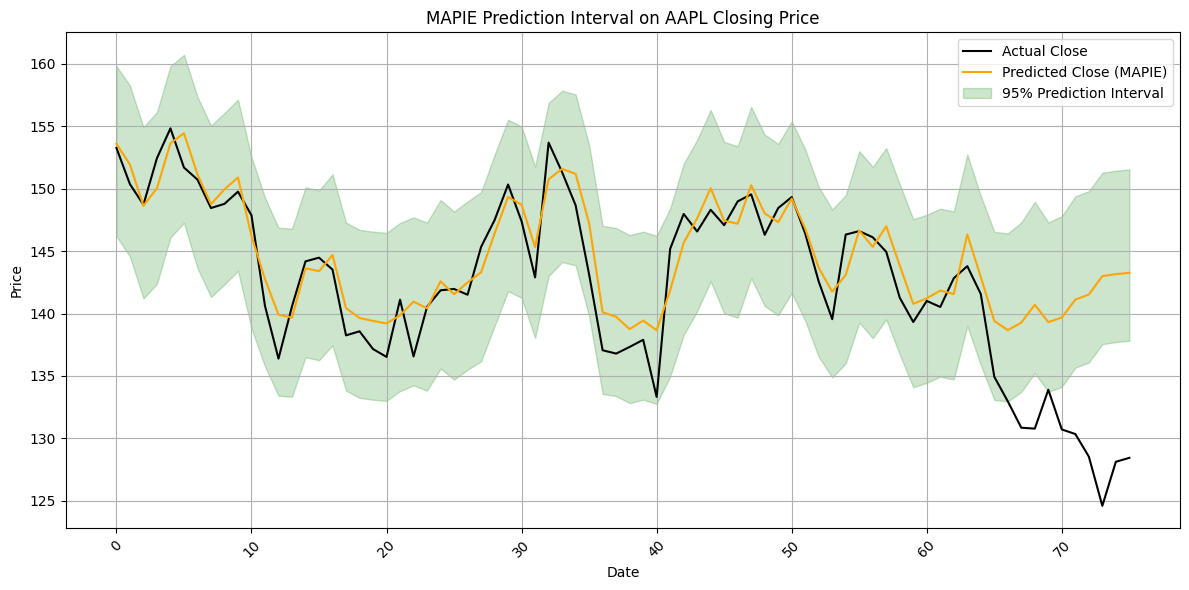

In [16]:
from mapie.regression import MapieRegressor

# 'plus' = Conformalized split method, compatible avec SVR
mapie = MapieRegressor(estimator=svm_model, method="plus")
mapie.fit(X_train_scaled, y_train)

# Prédiction avec intervalle à 90% (alpha=0.1)
y_pred, y_pis = mapie.predict(X_test_scaled, alpha=0.05)

# Reshape y_pis to be 2-dimensional
y_pis = y_pis.reshape((y_pis.shape[0], y_pis.shape[1]))

# Visualisation
plt.figure(figsize=(12, 6))
plt.plot(df_test.index, y_test, label='Actual Close', color='black')
plt.plot(df_test.index, y_pred, label='Predicted Close (MAPIE)', color='orange')
plt.fill_between(df_test.index, y_pis[:, 0], y_pis[:, 1], color='green', alpha=0.2, label='95% Prediction Interval')
plt.title('MAPIE Prediction Interval on AAPL Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
